In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any
from pandas.core.frame import DataFrame
from pandas import Series
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import os
from datetime import timedelta
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fpt_data=pd.read_csv('/content/drive/MyDrive/Barefoots/Vòng 2/Code/Main/PreTrain Data/FPT raw.csv')
cmc_data=pd.read_csv('/content/drive/MyDrive/Barefoots/Vòng 2/Code/Main/PreTrain Data/CMC raw.csv')

In [ ]:
df=fpt_data

df['price_shift_60'] = df['Close_FPT'].shift(-63)
df['return_60'] = (df['price_shift_60'] - df['Close_FPT']) * 100 / df['Close_FPT']
df.dropna(inplace=True)
if 'time' in df.columns:
      df['time'] = pd.to_datetime(df['Date'])
      df.set_index('time', inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler

def create_train_df_per_stock(features: np.array, label: np.array, lookback: int) -> tuple:
    X, y = [], []
    if label.ndim == 1:
        label = label.reshape(-1, 1)

    if len(features) < lookback:
        raise ValueError(f"Not enough data points for lookback. Data length: {len(features)}, Lookback: {lookback}")

    for i in range(lookback, len(features)):
        X.append(features[i-lookback:i])
        y.append(label[i])

    return np.array(X), np.array(y)

lookback = 150
target_column = 'Close_FPT_shift_60'

label_scaler = Pipeline([
    ('minmax_scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

feature_scaler = StandardScaler()

df = fpt_data[['Date', 'Open_FPT', 'High_FPT', 'Low_FPT', 'Volume_FPT', 'Close_FPT']].copy()

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

df[target_column] = df['Close_FPT'].shift(-3)
df.dropna(subset=[target_column], inplace=True)

print(df.head())
print("-" * 30)

print("Separating features and target...")
X_df = df.drop(columns=[target_column])
y_series = df[target_column]

print(f"Initial X_df shape: {X_df.shape}")
print(f"Initial y_series shape: {y_series.shape}")
print("-" * 30)

print("Scaling features...")
numerical_features = X_df.select_dtypes(include=np.number).columns
X_numerical_df = X_df[numerical_features]

X_scaled_numerical = feature_scaler.fit_transform(X_numerical_df)
print(f"Shape of scaled numerical features: {X_scaled_numerical.shape}")

print("Scaling target variable...")
y_values = y_series.values.reshape(-1, 1)
y_scaled = label_scaler.fit_transform(y_values)
print(f"Shape of scaled target: {y_scaled.shape}")
print("-" * 30)

print(f"Creating sequences with lookback={lookback}...")
X_sequences, y_sequences = create_train_df_per_stock(X_scaled_numerical, y_scaled, lookback)
print(f"Shape of X sequences: {X_sequences.shape}")
print(f"Shape of y sequences: {y_sequences.shape}")
print("-" * 30)

print("Splitting data into train and test sets (time-based)...")
split_ratio = 0.85
split_index = int(len(y_sequences) * split_ratio)

X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

print(f"Train/Test Split Ratio: {split_ratio}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("-" * 30)

print("Processing complete. You can now use:")
print("- X_train, y_train")
print("- X_test, y_test")
print("- feature_scaler (for future inputs)")
print("- label_scaler (to inverse_transform predictions)")


        Date  Open_FPT  High_FPT  Low_FPT  Volume_FPT  Close_FPT  \
0 2017-08-24     14.53     14.65    14.47      433820      14.62   
1 2017-08-25     14.65     14.67    14.56      374570      14.56   
2 2017-08-28     14.50     14.59    14.48      569140      14.59   
3 2017-08-29     14.56     14.74    14.54      828090      14.64   
4 2017-08-30     14.61     14.68    14.57      322140      14.65   

   Close_FPT_shift_60  
0               14.64  
1               14.65  
2               14.87  
3               14.90  
4               14.87  
------------------------------
Separating features and target...
Initial X_df shape: (1839, 6)
Initial y_series shape: (1839,)
------------------------------
Scaling features...
Shape of scaled numerical features: (1839, 5)
Scaling target variable...
Shape of scaled target: (1839, 1)
------------------------------
Creating sequences with lookback=150...
Shape of X sequences: (1689, 150, 5)
Shape of y sequences: (1689, 1)
----------------------

In [ ]:
print(pd.DataFrame(y_train).head())

          0
0 -1.020583
1 -1.026200
2 -1.013112
3 -0.993912
4 -1.020583


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

model = xgb.XGBRegressor()
model.fit(X_train_reshaped, y_train)
predictions = model.predict(X_test_reshaped)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

MAE: 0.5090
RMSE: 0.5616
R2: -4.8712


MAE: 0.5090
RMSE: 0.5616
R2: -4.8712


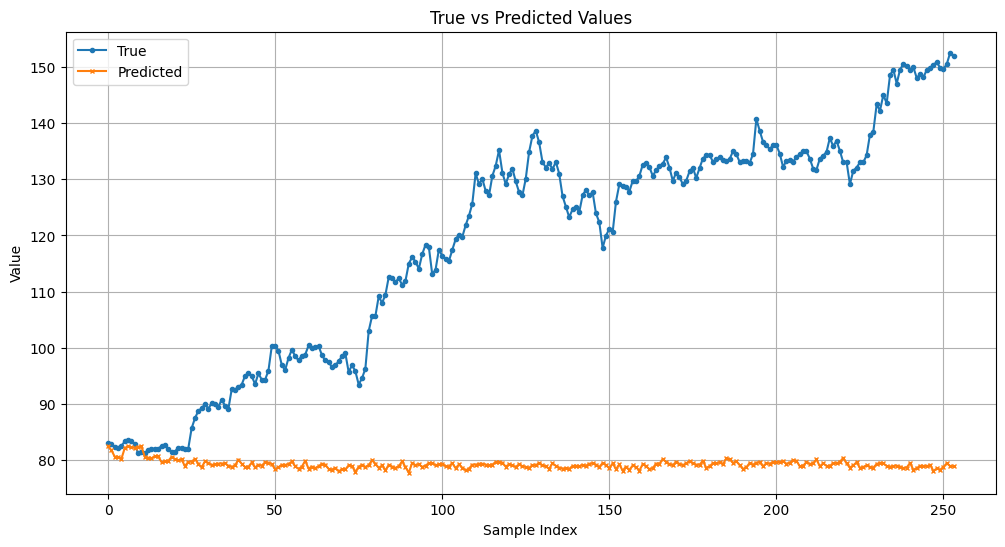

In [ ]:
y_test_inv = label_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions_inv = label_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True', marker='o', markersize=3)
plt.plot(predictions_inv, label='Predicted', marker='x', markersize=3)
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
fpt_data['Close_FPT']

,Close_FPT
0,14.62
1,14.56
2,14.59
3,14.64
4,14.65
...,...
1897,124.00
1898,121.00
1899,120.50
1900,122.00


In [ ]:
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001, scaler_y=None):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

                y_true.append(target.cpu().numpy())
                y_pred.append(output.cpu().numpy())

        val_loss /= len(val_loader)

        # Convert to arrays
        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)

        # Inverse transform if scaler provided
        if scaler_y is not None:
            y_true = scaler_y.inverse_transform(y_true)
            y_pred = scaler_y.inverse_transform(y_pred)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

    return model


Epoch 1/50, Train Loss: 0.0319, Val Loss: 0.0273
Epoch 2/50, Train Loss: 0.0125, Val Loss: 0.0107
Epoch 3/50, Train Loss: 0.0054, Val Loss: 0.0068
Epoch 4/50, Train Loss: 0.0030, Val Loss: 0.0049
Epoch 5/50, Train Loss: 0.0022, Val Loss: 0.0045
Epoch 6/50, Train Loss: 0.0049, Val Loss: 0.0037
Epoch 7/50, Train Loss: 0.0029, Val Loss: 0.0035
Epoch 8/50, Train Loss: 0.0031, Val Loss: 0.0065
Epoch 9/50, Train Loss: 0.0027, Val Loss: 0.0033
Epoch 10/50, Train Loss: 0.0045, Val Loss: 0.0036
Epoch 11/50, Train Loss: 0.0038, Val Loss: 0.0035
Epoch 12/50, Train Loss: 0.0071, Val Loss: 0.0029
Epoch 13/50, Train Loss: 0.0046, Val Loss: 0.0029
Epoch 14/50, Train Loss: 0.0082, Val Loss: 0.0032
Epoch 15/50, Train Loss: 0.0036, Val Loss: 0.0030
Epoch 16/50, Train Loss: 0.0109, Val Loss: 0.0045
Epoch 17/50, Train Loss: 0.0010, Val Loss: 0.0039
Epoch 18/50, Train Loss: 0.0009, Val Loss: 0.0033
Epoch 19/50, Train Loss: 0.0030, Val Loss: 0.0031
Epoch 20/50, Train Loss: 0.0099, Val Loss: 0.0026
Epoch 21/

In [ ]:
gru_model.eval()
with torch.no_grad():
    gru_preds = gru_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

print("GRU RMSE:", np.sqrt(mean_squared_error(y_test, gru_preds)))
print("GRU MAE:", mean_absolute_error(y_test, gru_preds))
print("GRU R2:", r2_score(y_test, gru_preds))

GRU RMSE: 0.1373752702243136
GRU MAE: 0.11581135856028303
GRU R2: 0.711741760691211


In [ ]:
import torch.nn.functional as F
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(CNN_BiLSTM_Attention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.dropout_conv = nn.Dropout(0.2)

        self.bi_lstm_1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=True)
        self.bi_lstm_2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)

        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

        self.fc1 = nn.Linear(128, 64)
        self.dropout_fc = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):

        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)

        x = x.permute(0, 2, 1)

        x, _ = self.bi_lstm_1(x)
        x, _ = self.bi_lstm_2(x)


        attn_output, _ = self.attention(x, x, x)  # self-attention

        pooled = attn_output.mean(dim=1)

        x = F.relu(self.fc1(pooled))
        x = self.dropout_fc(x)
        return self.fc2(x)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_gru, X_val_gru, y_train_gru, y_val_gru = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

train_loader, val_loader = create_data_loaders(X_train_gru, y_train_gru, X_val_gru, y_val_gru)
bi_model = CNN_BiLSTM_Attention(input_size=X_train.shape[2]).to(device)
bi_model = train_model(bi_model, train_loader, val_loader)

bi_model.eval()
with torch.no_grad():
    preds = bi_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

print("CNN-BiLSTM-Attn RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("CNN-BiLSTM-Attn MAE:", mean_absolute_error(y_test, preds))
print("CNN-BiLSTM-Attn R2:", r2_score(y_test, preds))

Epoch 001/50 | Train Loss: 0.250811 | Val Loss: 0.029802
Epoch 002/50 | Train Loss: 0.040469 | Val Loss: 0.023969
Epoch 003/50 | Train Loss: 0.031314 | Val Loss: 0.015199
Epoch 004/50 | Train Loss: 0.023807 | Val Loss: 0.012915
Epoch 005/50 | Train Loss: 0.023814 | Val Loss: 0.013567
Epoch 006/50 | Train Loss: 0.021247 | Val Loss: 0.011306
Epoch 007/50 | Train Loss: 0.019561 | Val Loss: 0.009028
Epoch 008/50 | Train Loss: 0.018919 | Val Loss: 0.013558
Epoch 009/50 | Train Loss: 0.019313 | Val Loss: 0.010497
Epoch 010/50 | Train Loss: 0.017655 | Val Loss: 0.008208
Epoch 011/50 | Train Loss: 0.016593 | Val Loss: 0.011513
Epoch 012/50 | Train Loss: 0.017476 | Val Loss: 0.007384
Epoch 013/50 | Train Loss: 0.016283 | Val Loss: 0.009511
Epoch 014/50 | Train Loss: 0.019459 | Val Loss: 0.007629
Epoch 015/50 | Train Loss: 0.018614 | Val Loss: 0.009571
Epoch 016/50 | Train Loss: 0.019656 | Val Loss: 0.007640
Epoch 017/50 | Train Loss: 0.015368 | Val Loss: 0.006605
Epoch 018/50 | Train Loss: 0.01